#  극도로 편향된 신용카드 사기 거래 data 분류
## Logistic Regression, Random Forest, Over/Under-sampling

- Highly Imbalanced Dataset - 284,807 거래 건 중 492 개의 사기거래


- [Credit Card Fraud Detection](https://www.kaggle.com/mlg-ulb/creditcardfraud) - Kaggle


- Highly Imbalanced Dataset - dataset는 2013 년 9 월 유럽 카드 소지자 신용 카드 거래로 만들었습니다. 이 dataset는 2 일 동안 발생한 거래를 보여 주며, 284,807 건의 거래 중 492 건의 fraud가 있습니다. 데이터세트는 매우 불균형하며 포지티브 클래스(사기)는 모든 거래의 0.172 %를 차지합니다.


- 이 dataset는 PCA 변환의 결과인 숫자 입력 변수만 포함합니다. 안타깝게도 기밀 유지 문제로 인해 데이터에 대한 원래 feature와 추가 background 정보를 제공할 수 없습니다. 
    - 특성 V1, V2, ... V28은 PCA로 얻은 principal component이며 PCA로 변환되지 않은 유일한 기능은 'Time' 과 'Amount' 입니다. 
    - '시간' 특성은 각 트랜잭션과 데이터 세트의 첫 번째 트랜잭션 사이에 경과된 시간(초) 입니다. 
    - 'Amount' 특성은 거래금액 입니다.  'Class'는 사기의 경우 1, 그렇지 않으면 0 입니다.


- 클래스 불균형 비율이 주어지면 Area Under the Precision-Recall Curve (AUPRC)을 사용하여 정확도를 측정하는 것이 좋습니다. 불균형 data 분류에는 confusion matrix 정확도가 의미가 없습니다.

In [45]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import confusion_matrix, f1_score
from sklearn.metrics import  accuracy_score, precision_score, recall_score, \
                            roc_curve, roc_auc_score
import seaborn as sns
from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

### Download the Kaggle Credit Card Fraud data set

In [46]:
df = pd.read_csv('https://storage.googleapis.com/download.tensorflow.org/data/creditcard.csv')

df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [47]:
df.shape

(284807, 31)

In [48]:
df.tail()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
284802,172786.0,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,...,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77,0
284803,172787.0,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,...,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79,0
284804,172788.0,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,...,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88,0
284805,172788.0,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,...,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00,0
284806,172792.0,-0.533413,-0.189733,0.703337,-0.506271,-0.012546,-0.649617,1.577006,-0.414650,0.486180,...,0.261057,0.643078,0.376777,0.008797,-0.473649,-0.818267,-0.002415,0.013649,217.00,0


- 정상(0), 사기(1) 거래 빈도수 구하기

In [49]:
df['Class'].unique()

array([0, 1])

In [50]:
df['Class'].value_counts()

0    284315
1       492
Name: Class, dtype: int64

In [51]:
neg = df['Class'].value_counts()[0]
pos = df['Class'].value_counts()[1]

print(neg, pos)
total = neg + pos

print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n' \
       .format(total, pos, 100 * pos / total))

284315 492
Examples:
    Total: 284807
    Positive: 492 (0.17% of total)



## Clean, split, 데이터 정규화

- `Time` column을 일중 시간으로 변환. 첫번 transaction 이 00:00:00 에 시작되었으므로, `(경과한 second)/3600초 % 24`로 시간 변환 

- `Amount`를 log 값으로 변환

In [52]:
cleaned_df = df.copy()

# Time 을 일중 시간으로 변환
cleaned_df.loc[:, "Time"] = \
        cleaned_df.loc[:, "Time"].apply(lambda x : x / 3600 % 24) 

# Amount column 은 편차가 크므로 log-scale 로 변환
# log0 는 -inf 이므로 작은 금액 add
eps=0.001      # 0 => 0.1¢
cleaned_df['Amount'] = np.log(cleaned_df.pop('Amount') + eps)

cleaned_df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Class,Amount
0,0.000000,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0,5.008105
1,0.000000,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0,0.989913
2,0.000278,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0,5.936641
3,0.000278,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0,4.816249
4,0.000556,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0,4.248367


- log 변환된 Amount의 분포 확인

In [53]:
cleaned_df['Amount'].describe()

count    284807.000000
mean          2.942089
std           2.023685
min          -6.907755
25%           1.722945
50%           3.091088
75%           4.345959
max          10.153902
Name: Amount, dtype: float64

- label data 작성

In [54]:
labels = np.array(cleaned_df.pop('Class'))
labels

array([0, 0, 0, ..., 0, 0, 0])

- input data 작성

In [55]:
features = cleaned_df.values
features.shape

(284807, 30)

- Class 분포 시각화

<AxesSubplot:ylabel='count'>

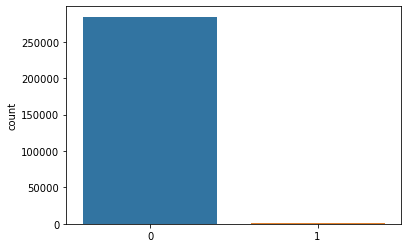

In [56]:
sns.countplot(x=labels)

label 1 의 비율

In [57]:
sum(labels == 1) / len(labels)

0.001727485630620034

dataset 을 Training 과 Test set 으로 분리

In [58]:
X_train, X_test, y_train, y_test = train_test_split(features, labels, 
                                test_size=0.2, random_state=0)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(227845, 30)
(56962, 30)
(227845,)
(56962,)


- train, test 내의 class 분포가 원래의 분포와 유사함을 확인

In [59]:
Counter(labels), Counter(y_train), Counter(y_test)

(Counter({0: 284315, 1: 492}),
 Counter({0: 227454, 1: 391}),
 Counter({0: 56861, 1: 101}))

### Feature Scaling

In [60]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test  = sc.transform(X_test)

### 0.17%의 극도로 편향된 Training set 에 대해 Logistic Regression model 을 fitting

In [61]:
lr_clf = LogisticRegression(random_state=0)
lr_clf.fit(X_train, y_train)

LogisticRegression(random_state=0)

### predict

- predict() - 확률 0.5 이상으로 예측된 class 를 positive case 로 반환   


- predict_proba() - class 의 probability 반환 ([negative 확률, positive 확률])

In [62]:
# predict()를 이용한 예측
y_pred_lr = lr_clf.predict(X_test)

print("Test set true counts = ", sum(y_test))
print("predicted true counts = ", sum(y_pred_lr))
print("accuracy = {:.5f}".format(sum(y_pred_lr == y_test) / len(y_test)))

Test set true counts =  101
predicted true counts =  72
accuracy = 0.99921


In [63]:
# predict_proba를 이용한 예측
y_pred_proba = lr_clf.predict_proba(X_test)

y_pred_proba_lr = y_pred_proba[:, 1]

sum(y_pred_proba_lr > 0.5)

72

## confusion matrix 를 이용한 model 평가

- threshold 를 이용하여 precision 과 recall 조정

In [64]:
def plot_cm(y_test, y_pred_proba, threshold):
    
    y_predict = y_pred_proba > threshold 
    
    cm = confusion_matrix(y_test, y_predict)
    
    print("confution matrix\n", cm)
    print()
    print("f1 score : ", f1_score(y_test, y_predict))
    print()
    print("Accuracy: {:.5f}".format(accuracy_score(y_test, y_predict)))
    print("Precision: {:.5f}".format(precision_score(y_test, y_predict)))
    print("Recall: {:.5f}".format(recall_score(y_test, y_predict)))
    
    plt.figure(figsize=(5,5))

    sns.heatmap(cm, annot=True, fmt="d")
    plt.title('Confusion matrix @>{:.2f} '.format(threshold))
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')

confution matrix
 [[56853     8]
 [   37    64]]

f1 score :  0.7398843930635838

Accuracy: 0.99921
Precision: 0.88889
Recall: 0.63366


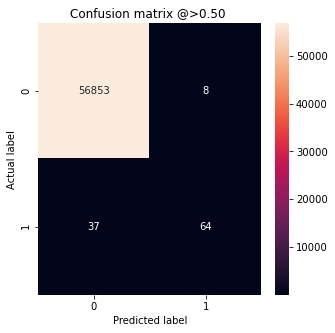

In [65]:
plot_cm(y_test, y_pred_proba_lr, 0.5)

### Fraud 거래를 잡아내는 것이 목적이므로, fraud case 를 놓치지 않으려면 recall 을 높인다.

이를 위해 threshold 를 조정.

confution matrix
 [[56850    11]
 [   28    73]]

f1 score :  0.7891891891891892

Accuracy: 0.99932
Precision: 0.86905
Recall: 0.72277


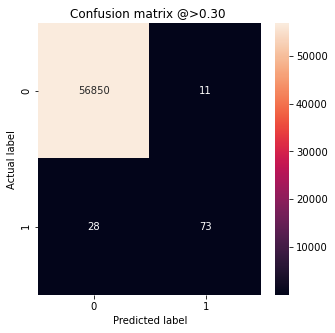

In [66]:
plot_cm(y_test, y_pred_proba_lr, 0.3)

## minority class를 Oversample 하고 majority class를 Undersample

- Over/Under Sampling 기법으로 minority data 의 수를 증가시켜 새로이 fitting

In [67]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

RandomOverSampler(sampling_strategy=0.1)

- 리샘플링 후 다수 클래스의 샘플 수에 대한 소수 클래스의 샘플 수의 원하는 비율  

In [68]:
over = RandomOverSampler(sampling_strategy=0.1)
X, y = over.fit_resample(X_train, y_train)
X.shape, y.shape, Counter(y)

((250199, 30), (250199,), Counter({0: 227454, 1: 22745}))

RandomUnderSampler(sampling_strategy=0.5)

- 리샘플링 후 다수 클래스의 샘플 수에 대한 소수 클래스의 샘플 수의 원하는 비율

In [69]:
under = RandomUnderSampler(sampling_strategy=0.5)
X, y = under.fit_resample(X, y)
X.shape, y.shape, Counter(y)

((68235, 30), (68235,), Counter({0: 45490, 1: 22745}))

<AxesSubplot:ylabel='count'>

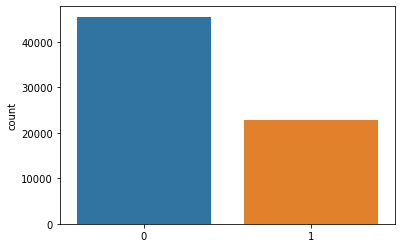

In [70]:
sns.countplot(x=y)

### 2:1%로 resampling된 dataset 에 대해 Logistic Regression model 을 fitting

In [71]:
re_lr_clf = LogisticRegression(max_iter=1000, random_state=0)
re_lr_clf.fit(X, y)

LogisticRegression(max_iter=1000, random_state=0)

### predict

In [72]:
y_pred_proba = re_lr_clf.predict_proba(X_test)

y_pred_proba_re_lr = y_pred_proba[:, 1]

sum(y_pred_proba_re_lr > 0.5)

744

confution matrix
 [[56208   653]
 [   10    91]]

f1 score :  0.21538461538461537

Accuracy: 0.98836
Precision: 0.12231
Recall: 0.90099


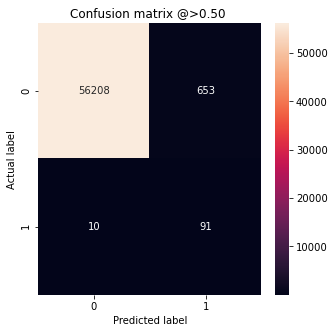

In [73]:
plot_cm(y_test, y_pred_proba_re_lr, 0.5)

## RandomForest 를 이용한 Classification

In [74]:
%%time
rf = RandomForestClassifier(n_estimators=100, verbose=1, n_jobs=5)
rf.fit(X, y)

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    4.4s


CPU times: user 17.9 s, sys: 50 ms, total: 17.9 s
Wall time: 9.09 s


[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    9.0s finished


RandomForestClassifier(n_jobs=2, verbose=1)

In [75]:
y_pred_rf = rf.predict(X_test)

print("Test set true counts = ", sum(y_test))
print("predicted true counts = ", sum(y_pred_rf))
print("accuracy = {:.5f}".format(sum(y_pred_rf == y_test) / len(y_test)))

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.4s finished


Test set true counts =  101
predicted true counts =  99
accuracy = 0.99944


- feature 중요도

In [76]:
rf.feature_importances_

array([0.00435458, 0.00660317, 0.03960405, 0.06708158, 0.07139216,
       0.00868754, 0.00513186, 0.0515793 , 0.00838821, 0.01075327,
       0.10343493, 0.08550554, 0.08891099, 0.00695723, 0.21387049,
       0.0066048 , 0.03907134, 0.08427911, 0.00814666, 0.0121168 ,
       0.00873221, 0.01527967, 0.00655763, 0.00584414, 0.00417996,
       0.0059534 , 0.00765341, 0.00739573, 0.0072597 , 0.00867055])

In [77]:
cleaned_df.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount'],
      dtype='object')

- feature 중요도 순으로 column 나열

In [78]:
sorted(list(zip(cleaned_df.columns, rf.feature_importances_)), 
       key=lambda kv: kv[1], reverse=True)

[('V14', 0.2138704944293825),
 ('V10', 0.10343493339306041),
 ('V12', 0.08891098560282192),
 ('V11', 0.0855055409664497),
 ('V17', 0.08427910758626218),
 ('V4', 0.07139216181939707),
 ('V3', 0.06708158265572868),
 ('V7', 0.0515792998036663),
 ('V2', 0.039604046874540014),
 ('V16', 0.03907133996947723),
 ('V21', 0.015279669888073407),
 ('V19', 0.012116799517702845),
 ('V9', 0.01075327345992291),
 ('V20', 0.008732205474169124),
 ('V5', 0.008687537469687116),
 ('Amount', 0.008670552422428774),
 ('V8', 0.008388210489580676),
 ('V18', 0.008146658609082138),
 ('V26', 0.007653414454543303),
 ('V27', 0.0073957295643262266),
 ('V28', 0.0072596973928207836),
 ('V13', 0.006957226044241028),
 ('V15', 0.0066048006831911435),
 ('V1', 0.006603171696726374),
 ('V22', 0.006557628566991813),
 ('V25', 0.005953395121068693),
 ('V23', 0.005844139969833963),
 ('V6', 0.005131858072743707),
 ('Time', 0.004354576290474611),
 ('V24', 0.00417996171160549)]

In [79]:
y_pred_proba = rf.predict_proba(X_test)

y_pred_proba_rf = y_pred_proba[:, 1]

sum(y_pred_proba_rf > 0.5)

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.2s finished


99

confution matrix
 [[56846    15]
 [   17    84]]

f1 score :  0.84

Accuracy: 0.99944
Precision: 0.84848
Recall: 0.83168


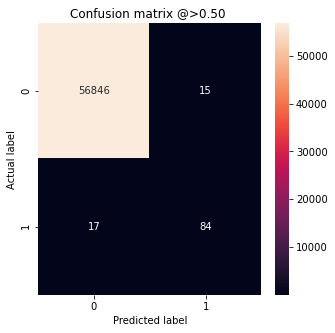

In [80]:
plot_cm(y_test, y_pred_proba_rf, 0.5)

## ROC 시각화를 통한 model들의 성능 비교

- roc_curve(y_true, y_score)  

- fpr - false positive rates,  tpr - true positive rates

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.2s finished


Text(0.5, 1.0, 'ROC Curve')

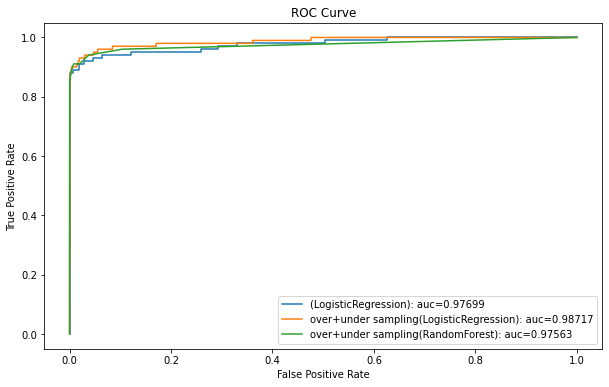

In [81]:
plt.figure(figsize=(10, 6))

y_probas = lr_clf.predict_proba(X_test)
y_scores = y_probas[:,1]
fpr, tpr, _ = roc_curve(y_test, y_scores)
auc = roc_auc_score(y_test, y_scores)
plt.plot(fpr, tpr, 
         label="(LogisticRegression): auc="+ "{:.5f}".format(auc))

y_probas = re_lr_clf.predict_proba(X_test)
y_scores = y_probas[:,1]
fpr, tpr, _ = roc_curve(y_test, y_scores)
auc = roc_auc_score(y_test, y_scores)
plt.plot(fpr, tpr, 
         label="over+under sampling(LogisticRegression): auc="+ "{:.5f}".format(auc))

y_probas = rf.predict_proba(X_test)
y_scores = y_probas[:,1]
fpr, tpr, _ = roc_curve(y_test, y_scores)
auc = roc_auc_score(y_test, y_scores)
plt.plot(fpr, tpr, 
         label="over+under sampling(RandomForest): auc="+ "{:.5f}".format(auc))

plt.legend(loc=4)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')